In [ ]:
# ==========================================
# CELL 1: INSTALL & IMPORTS
# ==========================================
# Install Hugging Face Transformers (Required for BERT)
# !pip install transformers

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
# Check for GPU
print(f"TensorFlow Version: {tf.__version__}")
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available. Training will be fast.")
else:
    print("⚠️ GPU not found. Go to Runtime > Change runtime type > T4 GPU.")

TensorFlow Version: 2.19.0
✅ GPU is available. Training will be fast.


In [ ]:
# ==========================================
# CELL 2: DATA LOADING
# ==========================================

# Define your exact file names
TRAIN_FILES = [
    "twitter-2013train-A.txt",
    "twitter-2015train-A.txt",
    "twitter-2016train-A.txt"
]

TEST_FILES = [
    "twitter-2013test-A.txt",
    "twitter-2015test-A.txt",
    "twitter-2016test-A.txt"
]

LABEL_MAP = {
    "positive": "positive",
    "negative": "negative",
    "neutral": "neutral",
    "objective-or-neutral": "neutral",
    "objective": "neutral"
}

In [ ]:
def load_single_file(path):
    if not os.path.exists(path):
        print(f"❌ Error: File not found '{path}'.")
        return pd.DataFrame()
    try:
        df = pd.read_csv(path, sep='\t', header=None, quoting=3, engine='python')
        # Standardize columns
        if df.shape[1] == 3:
            df.columns = ["ID", "Sentiment", "Text"]
        elif df.shape[1] >= 4:
            df = df.rename(columns={0: "ID", 2: "Sentiment", 3: "Text"})
            df = df[["ID", "Sentiment", "Text"]]
        return df
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return pd.DataFrame()

def load_data(files):
    dfs = [load_single_file(f) for f in files]
    dfs = [df for df in dfs if not df.empty] # Filter empty
    if not dfs: return pd.DataFrame(columns=["ID", "Sentiment", "Text"])

    df = pd.concat(dfs, ignore_index=True)
    df['Sentiment'] = df['Sentiment'].str.strip().str.lower().map(LABEL_MAP)
    return df.dropna(subset=['Sentiment', 'Text'])

print("\n[STEP 1] Loading Data...")
train_df = load_data(TRAIN_FILES)
test_df = load_data(TEST_FILES)

# Basic cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "url", text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+', 'user', text)
    return text

train_df['Clean_Text'] = train_df['Text'].apply(clean_text)
test_df['Clean_Text'] = test_df['Text'].apply(clean_text)

# print(f"Training samples: {len(train_df)}")
# print(f"Test samples:     {len(test_df)}")


[STEP 1] Loading Data...


In [ ]:
# ==========================================
# CELL 3: PREPROCESSING FOR BERT
# ==========================================
print("\n[STEP 2] Preparing Data for BERT...")

# 1. Encode Labels (Integers)
le = LabelEncoder()
all_labels = pd.concat([train_df['Sentiment'], test_df['Sentiment']]).unique()
le.fit(all_labels)

y_train = le.transform(train_df['Sentiment'])
y_test = le.transform(test_df['Sentiment'])
print(f"Classes: {le.classes_}")

# 2. Initialize BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


[STEP 2] Preparing Data for BERT...
Classes: ['negative' 'neutral' 'positive']


In [ ]:
# 3. Tokenization Function
def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

In [ ]:
# 3. Tokenization Function (Corrected)
def bert_encode(data, maximum_length):
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            padding='max_length',  # <--- FIXED: Changed from pad_to_max_length=True
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

# Encode data
MAX_LEN = 80
train_input_ids, train_attention_masks = bert_encode(train_df['Clean_Text'], MAX_LEN)
test_input_ids, test_attention_masks = bert_encode(test_df['Clean_Text'], MAX_LEN)

print("Data Encoding Complete.")

Data Encoding Complete.


In [ ]:
# ==========================================
# CELL 4: BUILD & TRAIN BERT MODEL (Fixed)
# ==========================================
print("\n[STEP 3] Building & Training BERT...")

# 1. Load Pre-trained BERT
# FIX: Added 'from_pt=True'. This forces it to load the PyTorch weights
# and convert them, avoiding the 'safe_open' error.
model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(le.classes_),
    from_pt=True
)

# 2. Compile
# Using a very small learning rate (2e-5) is standard for BERT fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# 3. Train
print("Starting Training...")
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_split=0.1,
    batch_size=16,  # Small batch size is better for BERT memory usage
    epochs=2        # BERT learns fast, 2 epochs is usually enough
)


[STEP 3] Building & Training BERT...


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training...
Epoch 1/2
366/366 [==============================] - 164s 296ms/step - loss: 0.8268 - accuracy: 0.6014 - val_loss: 0.6835 - val_accuracy: 0.6826
Epoch 2/2
366/366 [==============================] - 123s 337ms/step - loss: 0.5954 - accuracy: 0.7358 - val_loss: 0.6905 - val_accuracy: 0.6826



[STEP 4] Evaluation...
186/186 [==============================] - 48s 222ms/step

=== Classification Report (BERT) ===
              precision    recall  f1-score   support

    negative       0.86      0.22      0.36       924
     neutral       0.58      0.55      0.57      2500
    positive       0.63      0.84      0.72      2513

    accuracy                           0.62      5937
   macro avg       0.69      0.54      0.55      5937
weighted avg       0.65      0.62      0.60      5937



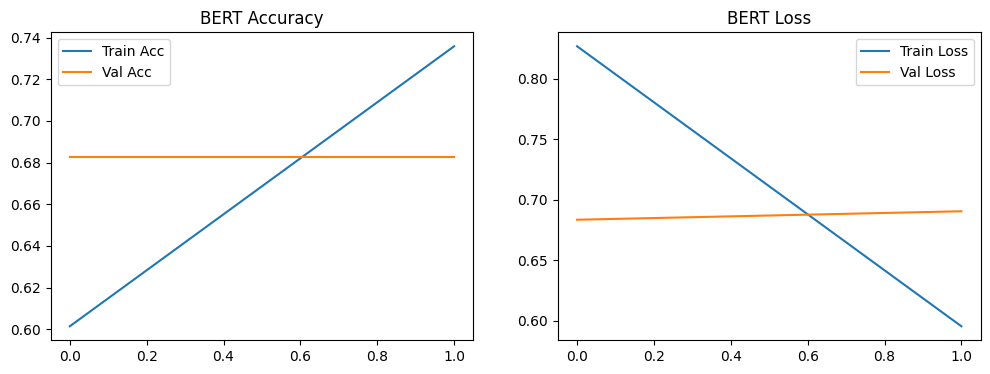

In [ ]:
# ==========================================
# CELL 5: EVALUATION
# ==========================================
print("\n[STEP 4] Evaluation...")

# Predict
preds = model.predict([test_input_ids, test_attention_masks])
y_pred = np.argmax(preds.logits, axis=1)

# Report
print("\n=== Classification Report (BERT) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('BERT Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('BERT Loss')
plt.legend()
plt.show()